### Introduction

In this notebook we will do image captioning on Microsoft COCO Dataset. We will be downloading the validation set, that contains around 41000 images for training. The data can be downloaded from [here](http://cocodataset.org/#download) form. 

We will also use Keras for training. For converting the images to vectors we will use the VGG16, pretrained model in Keras

I will be following the instructions at [this](https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html) URL for this notebook.

In [159]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

model = VGG16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________


We see that the last layer in the summary is used to classify the image into 1000 classes. Our objective is not to classify but to get a vector representation of the image. We therefore want to pop the last layer of this model and need the final layer to be `fc2`, which gives us a vector of dimension  4096.

Check the summary below after we pop the final layer off

In [160]:
#Pop off final layer, as if its a stack of layers with the head of the stack as the final layer
model.layers.pop()
model = Model(inputs = model.input, outputs = model.layers[-1].output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________


We will now download the dataset of it doesn't exists locally

In [161]:
from urllib.request import urlretrieve
import os
import zipfile

def maybe_download(zip_file_url, local_file_name, local_dir):
    local_full_file = os.path.join(local_dir, local_file_name)
    if not os.path.exists(local_dir):
        os.mkdir(local_dir)
    else:
        print('Directory "%s" exist'%local_dir)
        
    if os.path.exists(local_full_file):
        print('Validation zip %s exists, not downloading'%local_full_file)
    else:
        print('Downloading %s'%zip_file_url)
        urlretrieve(zip_url, local_full_file)
        print('File successfully downloaded')
     
    extraction_directory = os.path.join(local_dir, local_file_name[0:-4])
    
    if not os.path.exists(extraction_directory):        
        print('Unzipping file')
        os.mkdir(extraction_directory)
        zip_file = zipfile.ZipFile(local_full_file, 'r')
        zip_file.extractall(extraction_directory)
        zip_file.close()
        print('Zip file successfully extracted')
    else:
        print('Zip file already extracted')
    

print('\nDownloading Images')      
zip_url = 'http://images.cocodataset.org/zips/val2014.zip'
local_file_name = 'train_data.zip'
local_dir = 'coco-dataset'
maybe_download(zip_url, local_file_name, local_dir)
    
print('\nDownloading annotations')
zip_url = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
local_file_name = 'train_annotations.zip'
local_dir = 'coco-dataset'
maybe_download(zip_url, local_file_name, local_dir)
    


Directory "coco-dataset" exist
Validation zip coco-dataset/train_data.zip exists, not downloading
Zip file already extracted

Directory "coco-dataset" exist
Validation zip coco-dataset/train_annotations.zip exists, not downloading
Zip file already extracted


Create a dictionary of captions and image names

In [162]:
import json
with open(os.path.join(local_dir, 'train_annotations', 'annotations', 'captions_val2014.json')) as f:
    annotations = json.load(f)
    
    image_id_to_image_dict = {i['id']: os.path.join(local_dir, 'train_data', 'val2014', i['file_name']) for i in annotations['images']}
    image_id_to_caption_dict = {i['image_id']: i['caption'] for i in annotations['annotations']}

 
 Let us preview 5 random images

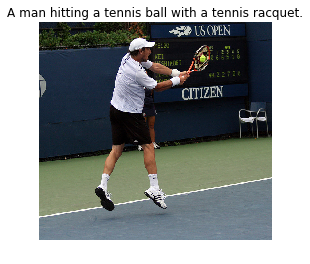

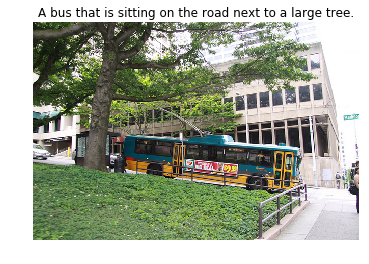

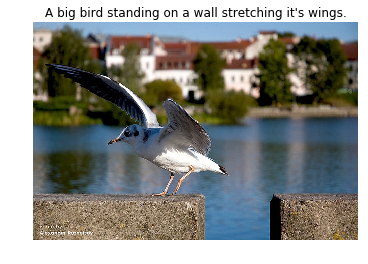

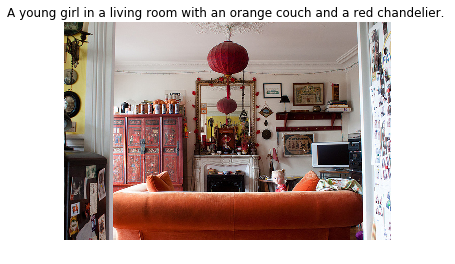

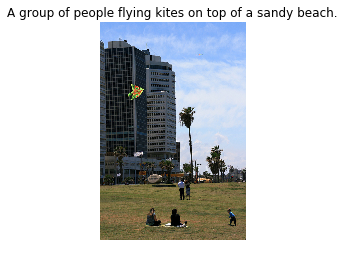

In [163]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_image_with_caption(image_id):
    im = Image.open(image_id_to_image_dict[image_id])
    fig = plt.imshow(im)
    ax = plt.gca()
    ax.set_title(image_id_to_caption_dict[image_id])
    plt.axis('off');
    plt.show()


keys = list(image_id_to_image_dict.keys())

random_5 = [ random.choice(keys) for _ in range(5)]

for img_id in random_5:
    show_image_with_caption(img_id)
    



Next step is to iterate through all images in the dataset and create a dictionary of the image vectors

In [ ]:
import numpy as np
from pickle import dump

features = dict()
file_names = image_id_to_image_dict.items()
deleted_images = []
print('Generating image vectors\n')
for idx, entry in enumerate(file_names):
    image_id, img_file = entry
    img = Image.open(img_file)
    img = img.resize((224, 224), Image.ANTIALIAS)
    img_arr = np.array(img)
    if len(img_arr.shape) != 3:
        deleted_images.append(image_id)
        print('Image %s has shape', img_arr.shape, 'skipping it from processing'%img_file)
        continue
    
    height, width, channels = img_arr.shape
    img_arr = img_arr.reshape(1, height, width, channels)
    img_vector = model.predict(img_arr)
    features[image_id] = img_vector
    if idx > 0 and idx % 10000 == 0:
        print('Processed %d images'%idx)

with open('coco_images_features.pkl', 'wb') as f:
    dump(features, f)


Generating image vectors

Image coco-dataset/train_data/val2014/COCO_val2014_000000559665.jpg has shape, skipping it from processing (224, 224)
Image coco-dataset/train_data/val2014/COCO_val2014_000000406404.jpg has shape, skipping it from processing (224, 224)
